In [27]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

替换中文为数字

In [28]:
data = pd.read_excel('./data.xlsx')
dict_map0 = {'非活动' : 0, '活动' : 1, '恢复' : 2}
dict_map1 = {'野牛沟' : 0, '才什土沟' : 1, '鹅堡' : 2}
data = data.replace(dict_map0)
data = data.replace(dict_map1)
data

,斑块,x1（ExG）,x2（ExRG）,x3（NGBDI）,x4（NGRDI）,x5（VDVI）,x6（VEG）,class1,class2
0,IMG_20220731_094811.0,3.064540,-65.477175,0.041164,-0.032936,-0.001568,0.9878,0,0
1,IMG_20220731_094816.0,11.210630,-76.685517,0.087938,-0.052268,0.002447,0.9924,1,0
2,IMG_20220731_094816.1,16.842886,-54.405715,0.114527,-0.033663,0.028094,1.0321,1,0
3,IMG_20220731_095731.0,10.429360,-55.429479,0.098313,-0.047090,0.013275,1.0065,0,0
4,IMG_20220731_095734.0,64.580250,27.384639,0.348371,0.054864,0.176371,1.3636,2,0
...,...,...,...,...,...,...,...,...,...
1705,IMG_20220803_104756.1,42.817580,-3.809599,0.153448,0.028329,0.086374,1.1661,0,1
1706,IMG_20220803_104804.0,31.005291,-20.949354,0.092575,0.017872,0.052802,1.1101,2,1
1707,IMG_20220803_104809.0,34.160666,-14.189711,0.146471,0.008871,0.070876,1.1395,2,1
1708,IMG_20220803_104828.0,38.791646,-13.225841,0.233914,-0.017885,0.086449,1.1551,2,1


class1 * class2 = 9, 分成9组, 依次删除每列属性离群点

In [29]:
data_res = None
for c1 in range(0, 3):
    for c2 in range(0, 3):
        data_tmp = data[(data['class1']==c1) & (data['class2']==c2)]
        # print(data_tmp.describe())
        for col in data.columns[1:-2]:
            iqr = data_tmp[col].quantile(0.75) - data_tmp[col].quantile(0.25)
            u_th = data_tmp[col].quantile(0.75) + 1.5 * iqr
            l_th = data_tmp[col].quantile(0.25) - 1.5 * iqr
            data_tmp = data_tmp[(l_th < data_tmp[col]) & (data_tmp[col] < u_th)]
        data_res = pd.concat([data_res, data_tmp], ignore_index=True)
        
data = data_res
data
            

,斑块,x1（ExG）,x2（ExRG）,x3（NGBDI）,x4（NGRDI）,x5（VDVI）,x6（VEG）,class1,class2
0,IMG_20220731_094811.0,3.064540,-65.477175,0.041164,-0.032936,-0.001568,0.9878,0,0
1,IMG_20220731_095731.0,10.429360,-55.429479,0.098313,-0.047090,0.013275,1.0065,0,0
2,IMG_20220731_095801.2,18.113776,-49.208397,0.133966,-0.040200,0.032165,1.0414,0,0
3,IMG_20220731_095841.0,2.250979,-68.728675,0.067211,-0.056255,-0.004714,0.9739,0,0
4,IMG_20220731_095910.0,21.153437,-31.963839,0.103401,0.006836,0.050106,1.1044,0,0
...,...,...,...,...,...,...,...,...,...
1592,IMG_20220730_151558.0,54.563290,5.369510,0.212039,0.029294,0.109303,1.2272,2,2
1593,IMG_20220730_151717.2,26.830835,-40.670770,0.118582,-0.005075,0.051739,1.0770,2,2
1594,IMG_20220730_151726.1,47.597681,2.764352,0.182618,0.031605,0.095951,1.2020,2,2
1595,IMG_20220730_151734.1,47.319323,7.153240,0.189728,0.060950,0.118623,1.2576,2,2


数据结构转化, 取得训练集和测试集

In [30]:
x = pd.concat([data.iloc[:,1:-2], data.iloc[:,-1:]], axis=1).values
# enc_tmp = OneHotEncoder()
# y = OneHotEncoder().fit_transform(np.array(data.iloc[:,-2:-1].values)).toarray()
y = np.array(data.iloc[:,-2:-1].values).reshape(1, data.shape[0])[0]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=666)
for i in range(0, 3):
    print(f'TRAIN - class1 : {i} has {np.count_nonzero(y_train == i)} cases')
for i in range(0, 3):
    print(f'TEST  - class1 : {i} has {np.count_nonzero(y_test == i)} cases')


TRAIN - class1 : 0 has 538 cases
TRAIN - class1 : 1 has 289 cases
TRAIN - class1 : 2 has 610 cases
TEST  - class1 : 0 has 63 cases
TEST  - class1 : 1 has 26 cases
TEST  - class1 : 2 has 71 cases


训练

[1]	valid_0's multi_logloss: 0.965274
[2]	valid_0's multi_logloss: 0.914552
[3]	valid_0's multi_logloss: 0.872311
[4]	valid_0's multi_logloss: 0.835074
[5]	valid_0's multi_logloss: 0.803323
[6]	valid_0's multi_logloss: 0.77527
[7]	valid_0's multi_logloss: 0.751772
[8]	valid_0's multi_logloss: 0.731877
[9]	valid_0's multi_logloss: 0.714159
[10]	valid_0's multi_logloss: 0.699769
[11]	valid_0's multi_logloss: 0.684607
[12]	valid_0's multi_logloss: 0.672587
[13]	valid_0's multi_logloss: 0.660965
[14]	valid_0's multi_logloss: 0.651343
[15]	valid_0's multi_logloss: 0.642715
[16]	valid_0's multi_logloss: 0.632679
[17]	valid_0's multi_logloss: 0.626043
[18]	valid_0's multi_logloss: 0.619859
[19]	valid_0's multi_logloss: 0.614656
[20]	valid_0's multi_logloss: 0.609358
[21]	valid_0's multi_logloss: 0.602884
[22]	valid_0's multi_logloss: 0.595145
[23]	valid_0's multi_logloss: 0.586419
[24]	valid_0's multi_logloss: 0.584584
[25]	valid_0's multi_logloss: 0.583181
[26]	valid_0's multi_logloss: 0.580

<AxesSubplot: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

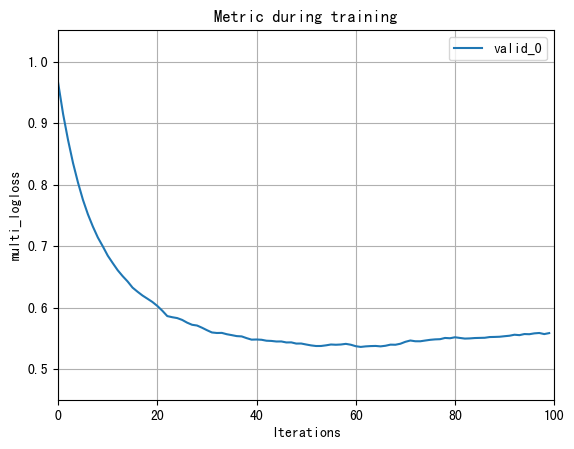

In [31]:
gbm = lgb.LGBMClassifier(objective='multiclass',
                         learning_rate=0.08)
gbm.fit(x_train, y_train, eval_set=[(x_test, y_test)])
lgb.plot_metric(gbm)

验证

In [32]:
y_pred = gbm.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.75625


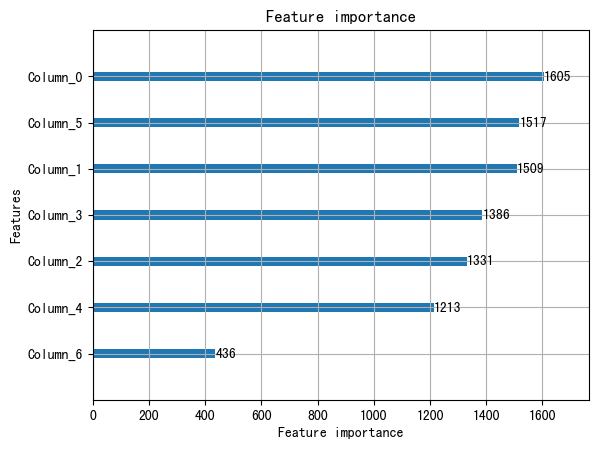

In [33]:
lgb.plot_importance(gbm)
plt.show()